In [ ]:
# WaveNet-based Character-level Language Model

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# Build the dataset
#block_size = 3 # context length: how many preceding characters to be part of the context?
block_size = 8 # from WaveNet paper
def build_dataset(words):
    X, Y = [], []

    for w in words:
      context = [0] * block_size
      for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80% in Training Split
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% in Dev Split
Xte, Yte = build_dataset(words[n2:])      # 10% in Test Split

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '---->', itos[y.item()])

........ ----> e
.......e ----> b
......eb ----> r
.....ebr ----> i
....ebri ----> m
...ebrim ----> a
..ebrima ----> .
........ ----> h
.......h ----> i
......hi ----> l
.....hil ----> t
....hilt ----> o
...hilto ----> n
..hilton ----> .
........ ----> j
.......j ----> h
......jh ----> e
.....jhe ----> n
....jhen ----> e
...jhene ----> .


In [ ]:
# Linear Layer
# PyTorch Linear Layers doc: https://pytorch.org/docs/stable/nn.html#linear-layers
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
#===============================================================================
# BatchNorm layer
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # Parameters trained using backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # Buffers (running mean and std-dev)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # Calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim , keepdim=True) # Batch Mean
      xvar = x.var(dim, keepdim=True) # Batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # Update the running buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

#===============================================================================

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

#===============================================================================

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

#===============================================================================

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n  # No. of consecutive elements to be flattened
  def __call__(self, x):    # (4, 8, 10) -> (4, 4, 20), n = 2.
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:   # If the first dimension is just 1 in length, then take it out.
      x = x.squeeze(1)    # After combining enough number of times, the middle
                          # dimension T//self.n will turn out to be 1. Eg:
                          # (4, 8, 10) -> (4, 4, 20) -> (4, 2, 40) -> (4, 1, 80)
                          # Instead of having a (4, 1, 80), the squeeze will
                          # remove that '1' dimension and gives (4, 80)
                          # Squeezing the 1st dimension (squeeze(1))
    self.out = x
    return self.out

  def parameters(self):
    return []

#===============================================================================

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # Get parameters of all layers and stretch them out into one single list
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42)   # Seed rng for reproducibility

In [ ]:
n_embd = 24     # Dimensionality of the character embedding vector
n_hidden = 128  # Number of neurons in the hidden layer of the MLP
                  # Similar to the previous MLP model.


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Kaiming He's Init
with torch.no_grad():
  # Last Layer: Make it less confident so that we are not
  # confidently wrong at initialization (Remember the loss being
  # 27.smth and coming down to 2.smh in 10k-20k iterations.
  # To save these 10+k iterations and use it on actual learning instead
  # of squashing output layer's random weights, we squash it here itself,
  # by multiplying it with 0.1)
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # Total no. of parameters
for p in parameters:
  p.requires_grad = True

76579


In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
print(Xb.shape, Yb.shape)
logits = model(Xb)
print(Xb.shape)
Xb
# Xb.shape = torch.Size([4, 8])

torch.Size([4, 8]) torch.Size([4])
torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  4,  5,  2, 15, 18,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [ ]:
e = torch.randn(32, 4, 68)                  # (32, 4, 68)
emean = e.mean((0, 1), keepdim=True)             # ( 1, 1, 68)
evar = e.var(0, keepdim=True)               # ( 1, 1, 68)
ehat = (e - emean)/ torch.sqrt(evar + 1e-5) # (32, 4, 68)
ehat.shape

torch.Size([32, 4, 68])

In [ ]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

In [ ]:
# Model Construction Done.
# Optimization (Forward Pass, Backward Pass, Update)
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

  # Forward Pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)   # Loss function

  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01    # Step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track statistics
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3203
  10000/ 200000: 1.9221
  20000/ 200000: 2.2397
  30000/ 200000: 2.3006
  40000/ 200000: 1.5550
  50000/ 200000: 2.1635
  60000/ 200000: 2.2097
  70000/ 200000: 1.8215
  80000/ 200000: 1.9500
  90000/ 200000: 1.8097
 100000/ 200000: 1.8010
 110000/ 200000: 1.7620
 120000/ 200000: 1.7861
 130000/ 200000: 1.4939
 140000/ 200000: 1.8820
 150000/ 200000: 1.6666
 160000/ 200000: 1.6456
 170000/ 200000: 2.0683
 180000/ 200000: 1.9526
 190000/ 200000: 1.9720


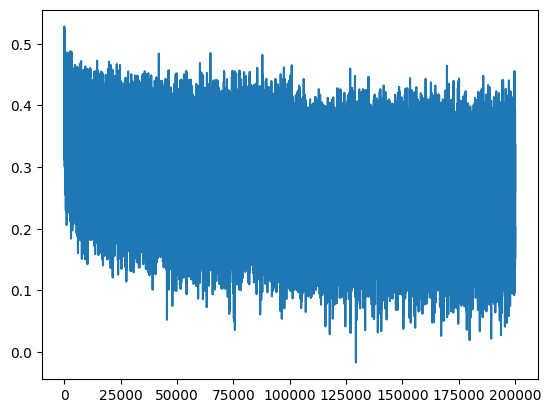

In [ ]:
plt.plot(lossi)

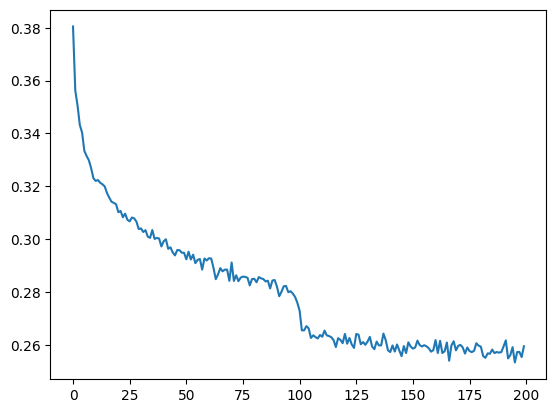

In [ ]:
# The above graph is simply the plot of 200,000 loss values, one for each
# iteration. Instead, better to take 1000 loss values at once, find their mean
# and plot all the means.

plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# Put layers into evaluation mode (needed for batchnorm)
for layer in model.layers:
  layer.training = False

In [ ]:
@torch.no_grad()    # This decorator disables gradient tracking

def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7850083112716675
val 1.9961260557174683


In [ ]:
# 1. Performance with block_size = 3 (Basic MLP model from lecture 4)
# # train 2.06659197807312
# val 2.1050572395324707
#
# Performance with just block_size = 8
# train 1.9307096004486084
# val 2.0324578285217285
#
# With block_size = 16
# train 1.9233500957489014
# val 2.026993989944458
#
# With the WaveNet model, but with n_hidden = 68 (instead of 200)
# train 1.951379418373108
# val 2.034548759460449
#
# BatchNorm bug resolved,
# train 1.923056960105896
# val 2.0267248153686523
#
#
#
# Just increasing the context improve the model.

In [ ]:
for _ in range(20):

  out = []
  context = [0] * block_size    # Initialize with all
  while True:
    # Forward pass the neural network
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)

    # Sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # Shift the context window and track samples
    context = context[1:] + [ix]
    out.append(ix)

    # If we get/sample a '.', that is the end of the word, we break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # Decode and print generated words

sameeb.
crucklin.
amania.
shane.
zaelyn.
crisper.
christianni.
kissah.
jacion.
anthonya.
merre.
hadah.
albasia.
knkeemi.
bentzen.
braddynn.
loven.
aviyana.
cymia.
yitzavik.
